In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# READ IN ALL DATA
ticker = 'CLOV'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\CLOV_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,2021-01-05,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     261 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '2D%Change', 'SD', '4D%Change', '6Dir', '3Dir', '5Dir', '4Dir', 'SD_log', 'Volume', 'Low', '7Dir', '7D%Change', '3D%Change', 'Dir', 'Open', '6D%Change', '2Dir', 'Daily%Change', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,7Dir(t-1),7D%Change(t-1),3D%Change(t-1),Dir(t-1),Open(t-1),6D%Change(t-1),2Dir(t-1),Daily%Change(t-1),High(t-1),Close(t-1)
15,13.81,0,2.0,7.0,9.0,77.776914,6.0,3.0,100.0,14.0,...,1.0,1.602333,-11.484774,0.0,14.05,2.649004,0.0,-0.852878,14.70,13.95
26,11.32,2,1.0,1.0,2.0,49.997500,1.0,0.5,100.0,2.0,...,0.0,-6.050693,-8.080002,0.0,12.20,-11.136895,0.0,-4.884107,12.23,11.49
33,9.40,4,2.0,1.0,3.0,33.332222,2.0,1.0,100.0,1.0,...,0.0,-15.491730,-12.364620,0.0,10.30,-14.222612,0.0,-6.092844,10.57,9.71
37,7.29,3,14.0,10.0,24.0,41.666493,14.0,7.0,100.0,11.0,...,0.0,-25.180505,-11.808507,0.0,8.99,-18.163871,0.0,-8.296460,9.28,8.29
38,7.84,4,7.0,1.0,8.0,12.499844,21.0,10.5,100.0,11.0,...,0.0,-28.035539,-29.701060,0.0,8.08,-29.497100,0.0,-12.062726,8.27,7.29


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,7D%Change(t-1),3D%Change(t-1),Dir(t-1),Open(t-1),6D%Change(t-1),2Dir(t-1),Daily%Change(t-1),High(t-1),Close(t-1),Prediction
230,4.60,1,1.0,2.0,3.0,66.664445,1.0,0.5,100.0,2.0,...,-19.216421,-3.131988,1.0,4.170,-19.963031,0.0,0.697668,4.440,4.33,4.60
231,4.65,2,9.0,1.0,10.0,9.999900,10.0,5.0,100.0,3.0,...,-14.972273,2.222220,1.0,4.430,-9.448819,1.0,6.235565,4.800,4.60,4.65
232,4.45,3,2.0,5.0,7.0,71.427551,11.0,5.5,100.0,6.0,...,-8.464564,8.139532,1.0,4.550,-6.249999,1.0,1.086961,4.750,4.65,4.45
237,3.98,3,1.0,1.0,2.0,49.997500,1.0,0.5,100.0,1.0,...,-4.618933,-6.561085,1.0,4.010,-10.217387,0.0,2.227727,4.190,4.13,3.98
242,4.20,3,12.0,6.0,18.0,33.333148,17.0,8.5,100.0,6.0,...,-3.537727,-2.386633,0.0,4.083,1.237628,1.0,-0.243896,4.219,4.09,4.20


In [7]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(121, 100)
(37, 100)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(114, 7, 100) (114,)
(30, 7, 100) (30,)
0.11741681531928222
0.11741681531928222


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.2928
Epoch 1: val_loss improved from inf to 0.09354, saving model to CLOV_Close_1shift_Sentiment.h5
8/8 [==============================] - 7s 402ms/step - loss: 0.2928 - val_loss: 0.0935
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0335
Epoch 2: val_loss improved from 0.09354 to 0.00747, saving model to CLOV_Close_1shift_Sentiment.h5
8/8 [==============================] - 2s 293ms/step - loss: 0.0335 - val_loss: 0.0075
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0194
Epoch 3: val_loss did not improve from 0.00747
8/8 [==============================] - 2s 239ms/step - loss: 0.0194 - val_loss: 0.0314
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0138
Epoch 4: val_loss did not improve from 0.00747
8/8 [==============================] - 2s 256ms/step - loss: 0.0138 - val_loss: 0.0153
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0

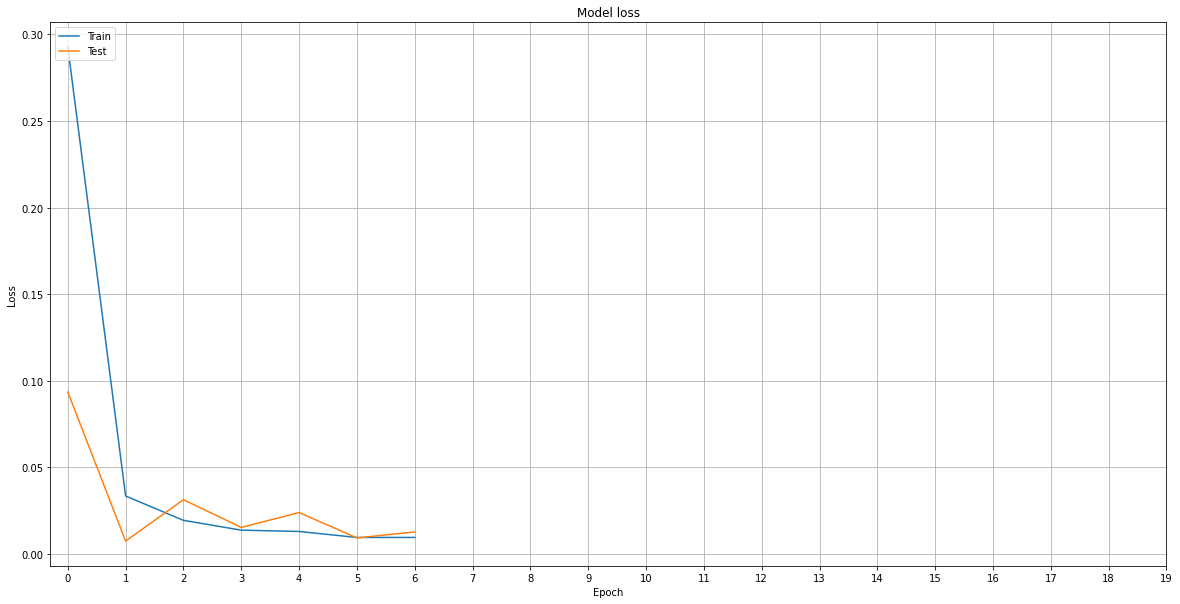

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 1.0
Mean Absolute Percentage Error (MAPE): 19.15 %
Median Absolute Percentage Error (MDAPE): 9.65 %


,MAE,MAPE,MDAPE
0,0.997529,19.148167,9.6538


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

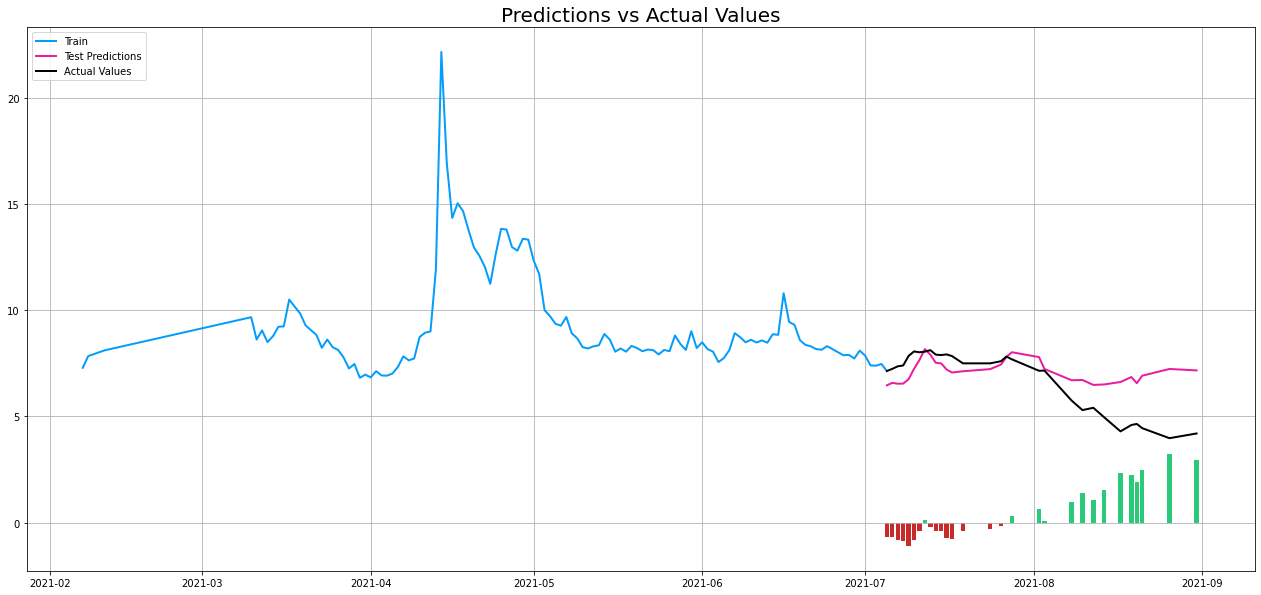

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '2D%Change', 'SD', '4D%Change', '6Dir', '3Dir', '5Dir', '4Dir', 'SD_log', 'Volume', 'Low', '7Dir', '7D%Change', '3D%Change', 'Dir', 'Open', '6D%Change', '2Dir', 'Daily%Change', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,7Dir(t-4),7D%Change(t-4),3D%Change(t-4),Dir(t-4),Open(t-4),6D%Change(t-4),2Dir(t-4),Daily%Change(t-4),High(t-4),Close(t-4)
17,13.95,2,4.0,7.0,11.0,63.635785,4.0,2.0,100.0,7.0,...,1.0,2.327271,1.005021,0.0,14.78,2.476330,0.0,-1.263160,15.45,14.07
18,12.23,3,2.0,7.0,9.0,77.776914,6.0,3.0,100.0,14.0,...,1.0,1.602333,-11.484774,0.0,14.05,2.649004,0.0,-0.852878,14.70,13.95
34,10.37,0,2.0,1.0,3.0,33.332222,2.0,1.0,100.0,1.0,...,0.0,-15.653623,-6.463526,0.0,10.62,-16.142383,0.0,-8.574006,10.88,10.13
39,7.35,0,7.0,1.0,8.0,12.499844,21.0,10.5,100.0,11.0,...,0.0,-17.668485,-6.900104,0.0,9.85,-18.411552,0.0,-12.825457,9.85,9.04
69,8.62,1,29.0,7.0,36.0,19.444390,29.0,14.5,100.0,7.0,...,0.0,-1.066666,-9.622411,0.0,7.87,-2.496716,0.0,-4.993596,7.87,7.42


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,7D%Change(t-4),3D%Change(t-4),Dir(t-4),Open(t-4),6D%Change(t-4),2Dir(t-4),Daily%Change(t-4),High(t-4),Close(t-4),Prediction
228,4.30,4,3.0,1.0,4.0,24.999375,3.0,1.5,100.0,1.0,...,-20.995333,-4.150948,0.0,5.460,-9.447419,0.0,-6.099814,5.490,5.08,4.30
229,4.33,0,70.0,12.0,82.0,14.634128,70.0,35.0,6900.0,12.0,...,-11.586454,-7.462688,0.0,5.000,-13.739130,0.0,-2.362203,5.080,4.96,4.33
230,4.60,1,38.0,5.0,43.0,11.627880,108.0,54.0,100.0,17.0,...,-22.260873,-17.375233,0.0,4.960,-17.679559,0.0,-9.879037,5.020,4.47,4.60
233,4.42,4,1.0,2.0,3.0,66.664445,1.0,0.5,100.0,2.0,...,-19.216421,-3.131988,1.0,4.170,-19.963031,0.0,0.697668,4.440,4.33,4.42
245,3.74,2,62.0,4.0,66.0,6.060597,63.0,31.5,3000.0,4.0,...,-3.537727,-2.386633,0.0,4.083,1.237628,1.0,-0.243896,4.219,4.09,3.74


In [17]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(119, 100)
(36, 100)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(112, 7, 100) (112,)
(29, 7, 100) (29,)
0.1272015888102706
0.1272015888102706


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.7034
Epoch 1: val_loss improved from inf to 0.05654, saving model to CLOV_Close_4shift_Sentiment.h5
7/7 [==============================] - 6s 425ms/step - loss: 0.7034 - val_loss: 0.0565
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0422
Epoch 2: val_loss improved from 0.05654 to 0.00759, saving model to CLOV_Close_4shift_Sentiment.h5
7/7 [==============================] - 2s 286ms/step - loss: 0.0422 - val_loss: 0.0076
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0363
Epoch 3: val_loss did not improve from 0.00759
7/7 [==============================] - 2s 259ms/step - loss: 0.0363 - val_loss: 0.0187
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0193
Epoch 4: val_loss did not improve from 0.00759
7/7 [==============================] - 2s 267ms/step - loss: 0.0193 - val_loss: 0.0268
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 0

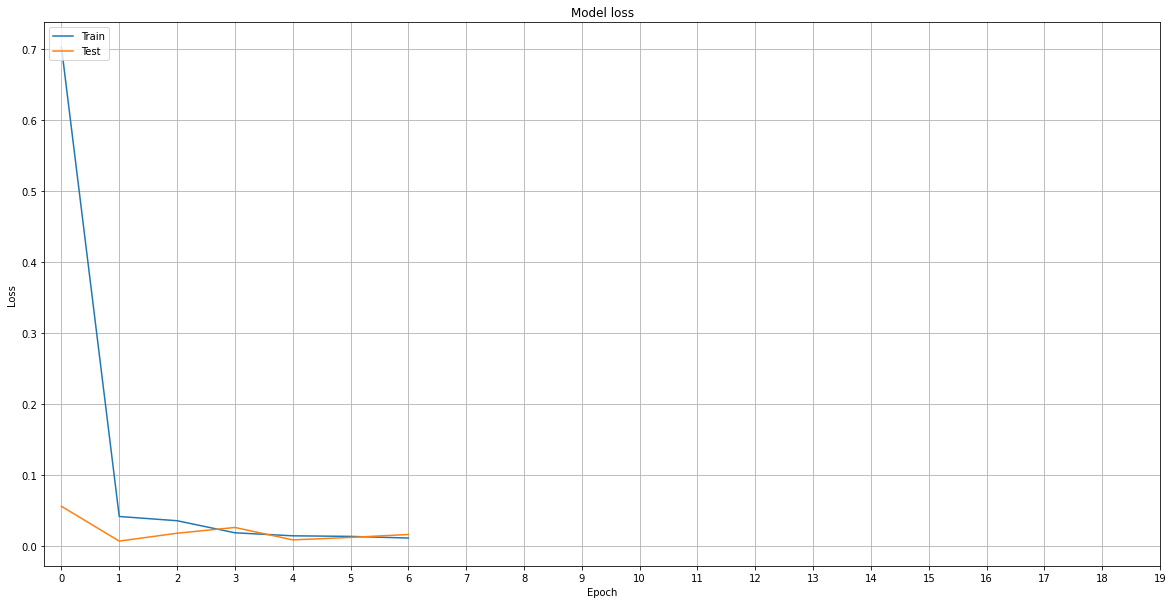

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 1.02
Mean Absolute Percentage Error (MAPE): 19.19 %
Median Absolute Percentage Error (MDAPE): 8.67 %


,MAE,MAPE,MDAPE
0,1.023906,19.188244,8.67331


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

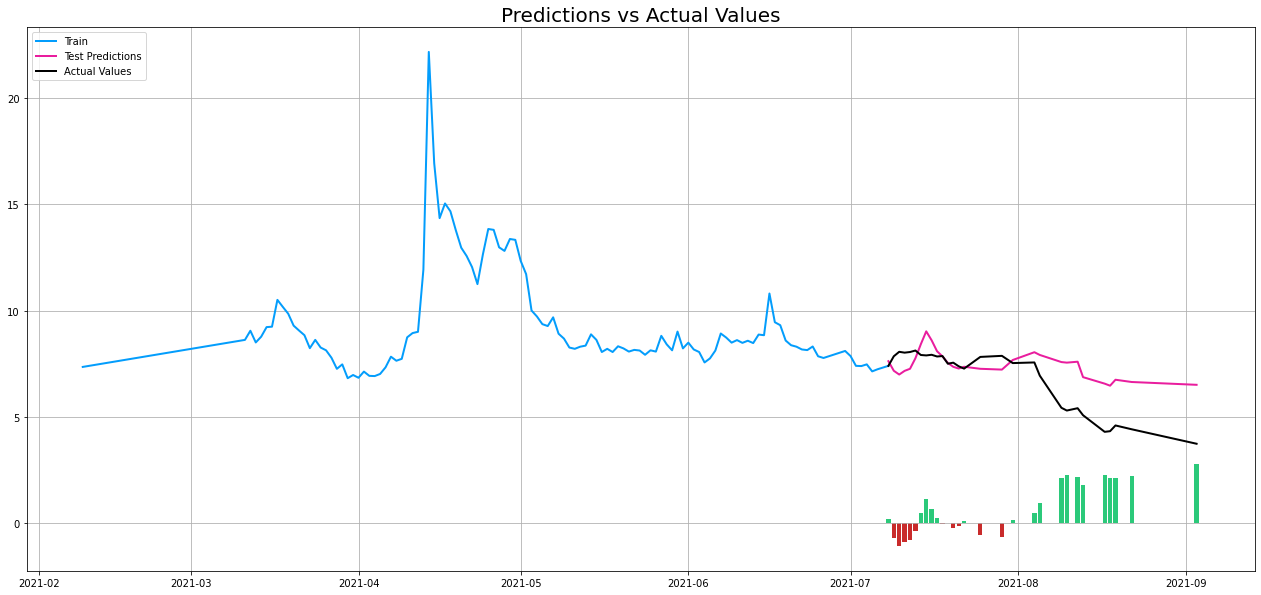

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [25]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '2D%Change', 'SD', '4D%Change', '6Dir', '3Dir', '5Dir', '4Dir', 'SD_log', 'Volume', 'Low', '7Dir', '7D%Change', '3D%Change', 'Dir', 'Open', '6D%Change', '2Dir', 'Daily%Change', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,7Dir(t-7),7D%Change(t-7),3D%Change(t-7),Dir(t-7),Open(t-7),6D%Change(t-7),2Dir(t-7),Daily%Change(t-7),High(t-7),Close(t-7)
30,10.13,1,1.0,1.0,2.0,49.997500,1.0,0.5,100.0,2.0,...,0.0,-14.030064,-2.910264,0.0,12.38,-13.906807,0.0,-3.919998,12.48,12.01
37,7.29,3,2.0,1.0,3.0,33.332222,2.0,1.0,100.0,1.0,...,0.0,-15.653623,-6.463526,0.0,10.62,-16.142383,0.0,-8.574006,10.88,10.13
41,8.11,2,14.0,10.0,24.0,41.666493,14.0,7.0,100.0,11.0,...,0.0,-4.247461,0.290133,1.0,9.97,-5.555553,1.0,10.319152,10.82,10.37
42,8.67,3,7.0,1.0,8.0,12.499844,21.0,10.5,100.0,11.0,...,0.0,-17.668485,-6.900104,0.0,9.85,-18.411552,0.0,-12.825457,9.85,9.04
45,8.61,1,1.0,2.0,3.0,66.664445,1.0,0.5,100.0,2.0,...,0.0,-24.177949,-13.274334,1.0,7.62,-19.258495,0.0,7.544584,7.96,7.84


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,7D%Change(t-7),3D%Change(t-7),Dir(t-7),Open(t-7),6D%Change(t-7),2Dir(t-7),Daily%Change(t-7),High(t-7),Close(t-7),Prediction
234,4.24,0,1.0,2.0,3.0,66.664445,1.0,0.5,100.0,2.0,...,-17.127069,-11.417322,1.0,4.480,-15.094343,0.0,0.671146,4.630,4.50,4.24
235,4.04,1,9.0,1.0,10.0,9.999900,10.0,5.0,100.0,3.0,...,-18.867924,-13.306448,0.0,4.561,-19.776118,0.0,-4.444440,4.561,4.30,4.04
236,4.13,2,2.0,5.0,7.0,71.427551,11.0,5.5,100.0,6.0,...,-19.216421,-3.131988,1.0,4.170,-19.963031,0.0,0.697668,4.440,4.33,4.13
241,4.09,2,1.0,1.0,2.0,49.997500,1.0,0.5,100.0,1.0,...,-5.777783,-8.817211,0.0,4.340,-1.395359,0.0,-4.072405,4.420,4.24,4.09
245,3.74,2,12.0,6.0,18.0,33.333148,17.0,8.5,100.0,6.0,...,-9.892474,3.712874,1.0,3.940,-5.842691,1.0,5.276383,4.305,4.19,3.74


In [27]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(125, 100)
(38, 100)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(118, 7, 100) (118,)
(31, 7, 100) (31,)
0.15786038400354035
0.15786038400354035


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.9073
Epoch 1: val_loss improved from inf to 0.12942, saving model to CLOV_Close_7shift_Sentiment.h5
8/8 [==============================] - 7s 404ms/step - loss: 0.9073 - val_loss: 0.1294
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0485
Epoch 2: val_loss improved from 0.12942 to 0.01137, saving model to CLOV_Close_7shift_Sentiment.h5
8/8 [==============================] - 3s 325ms/step - loss: 0.0485 - val_loss: 0.0114
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.0300
Epoch 3: val_loss did not improve from 0.01137
8/8 [==============================] - 2s 258ms/step - loss: 0.0300 - val_loss: 0.0405
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.0210
Epoch 4: val_loss did not improve from 0.01137
8/8 [==============================] - 2s 257ms/step - loss: 0.0210 - val_loss: 0.0290
Epoch 5/100
8/8 [==============================] - ETA: 0s - loss: 0

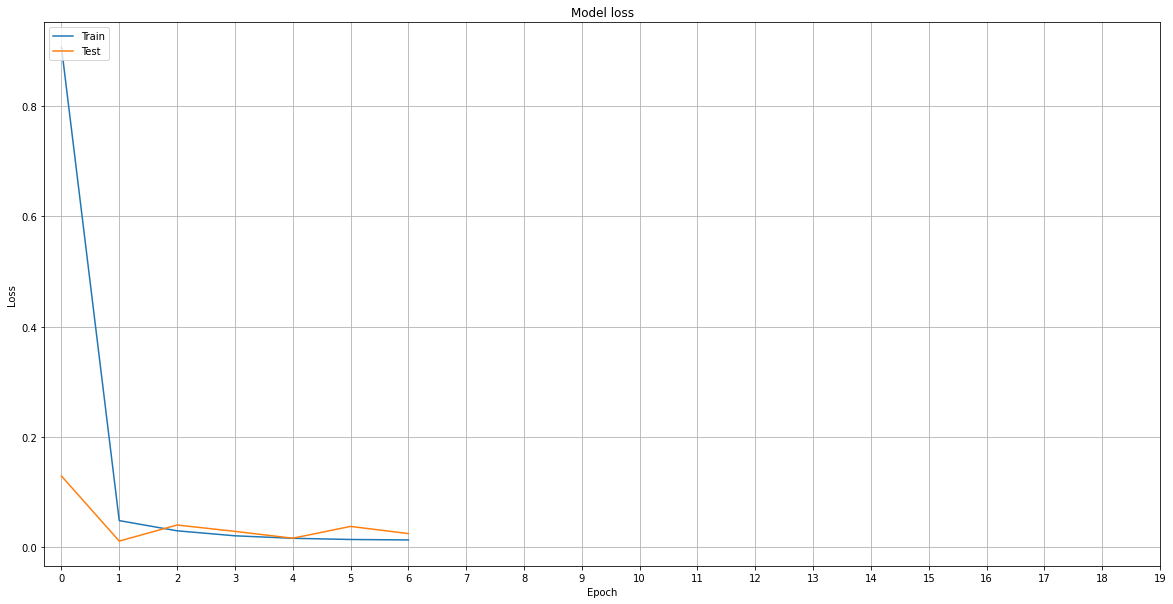

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 1.36
Mean Absolute Percentage Error (MAPE): 26.99 %
Median Absolute Percentage Error (MDAPE): 18.18 %


,MAE,MAPE,MDAPE
0,1.357391,26.988675,18.183361


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

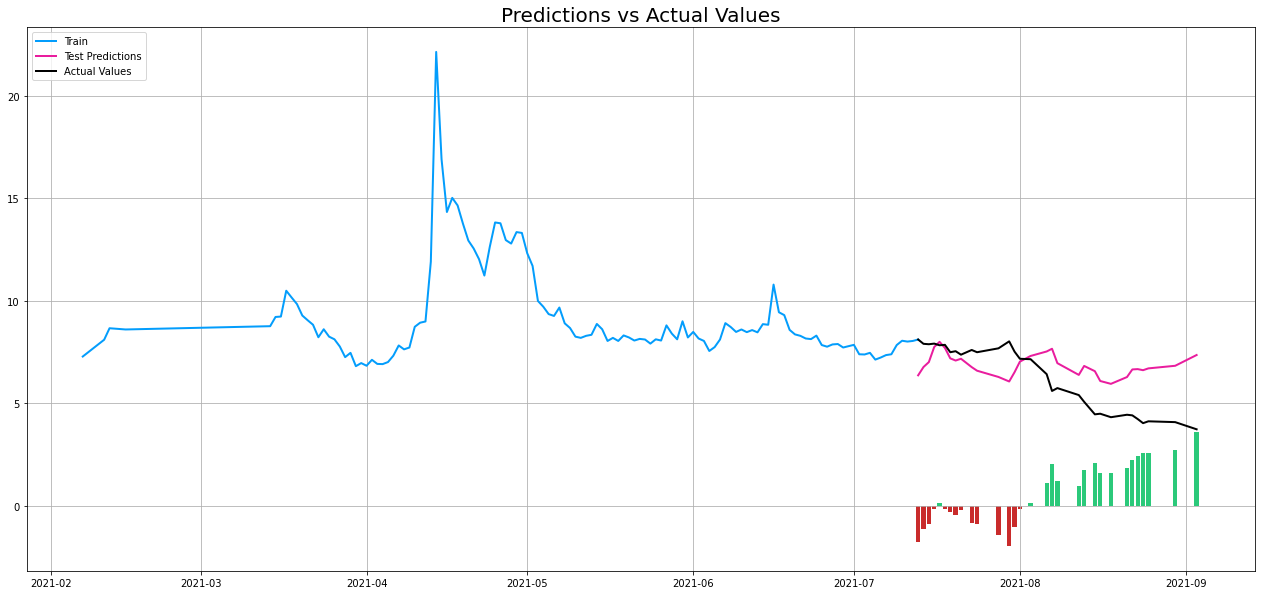

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [35]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '2D%Change', 'SD', '4D%Change', '6Dir', '3Dir', '5Dir', '4Dir', 'SD_log', 'Volume', 'Low', '7Dir', '7D%Change', '3D%Change', 'Dir', 'Open', '6D%Change', '2Dir', 'Daily%Change', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,7Dir(t-1),7D%Change(t-1),3D%Change(t-1),Dir(t-1),Open(t-1),6D%Change(t-1),2Dir(t-1),Daily%Change(t-1),High(t-1),Close(t-1)
15,13.81,0,9.0,20.0,10.0,100.000000,20.0,6.666667,100.0,20.0,...,1.0,1.602333,-11.484774,0.0,14.050,2.649004,0.0,-0.852878,14.70,13.95
16,13.97,1,1.0,10.0,5.0,-90.909091,21.0,7.000000,100.0,21.0,...,1.0,1.618839,-3.087716,0.0,14.130,1.918821,0.0,-1.003580,14.40,13.81
25,11.49,1,1.0,1.0,0.5,100.000000,1.0,0.333333,100.0,1.0,...,0.0,-13.405017,-8.206686,1.0,11.925,-1.226489,0.0,0.582845,12.39,12.08
26,11.32,2,2.0,3.0,1.5,100.000000,3.0,1.000000,100.0,3.0,...,0.0,-6.050693,-8.080002,0.0,12.200,-11.136895,0.0,-4.884107,12.23,11.49
33,9.40,4,3.0,3.0,1.5,100.000000,3.0,1.000000,100.0,3.0,...,0.0,-15.491730,-12.364620,0.0,10.300,-14.222612,0.0,-6.092844,10.57,9.71


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,7D%Change(t-1),3D%Change(t-1),Dir(t-1),Open(t-1),6D%Change(t-1),2Dir(t-1),Daily%Change(t-1),High(t-1),Close(t-1),Prediction
232,4.45,3,7.0,17.0,8.5,133.333333,20.0,6.666667,100.0,20.0,...,-8.464564,8.139532,1.0,4.550,-6.249999,1.0,1.086961,4.750,4.65,4.45
237,3.98,3,2.0,2.0,1.0,100.000000,2.0,0.666667,100.0,2.0,...,-4.618933,-6.561085,1.0,4.010,-10.217387,0.0,2.227727,4.190,4.13,3.98
241,4.09,2,5.0,5.0,2.5,100.000000,5.0,1.666667,100.0,5.0,...,-7.239823,3.015072,1.0,4.020,-3.301884,0.0,3.274556,4.130,4.10,4.09
242,4.20,3,18.0,23.0,11.5,100.000000,23.0,7.666667,100.0,23.0,...,-3.537727,-2.386633,0.0,4.083,1.237628,1.0,-0.243896,4.219,4.09,4.20
244,3.89,1,2.0,2.0,1.0,-96.969697,68.0,22.666667,100.0,69.0,...,-1.937044,-1.219505,0.0,4.160,1.758798,0.0,-3.571420,4.190,4.05,3.89


In [37]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(140, 43)
(42, 43)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(133, 7, 43) (133,)
(35, 7, 43) (35,)
0.06653620467904481
0.06653620467904481


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.0954
Epoch 1: val_loss improved from inf to 0.04520, saving model to CLOV_Close_1shift_Baseline.h5
9/9 [==============================] - 5s 179ms/step - loss: 0.0954 - val_loss: 0.0452
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.0205
Epoch 2: val_loss improved from 0.04520 to 0.01059, saving model to CLOV_Close_1shift_Baseline.h5
9/9 [==============================] - 1s 74ms/step - loss: 0.0205 - val_loss: 0.0106
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.0133
Epoch 3: val_loss did not improve from 0.01059
9/9 [==============================] - 1s 67ms/step - loss: 0.0133 - val_loss: 0.0191
Epoch 4/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0098
Epoch 4: val_loss did not improve from 0.01059
9/9 [==============================] - 1s 66ms/step - loss: 0.0096 - val_loss: 0.0132
Epoch 5/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0082

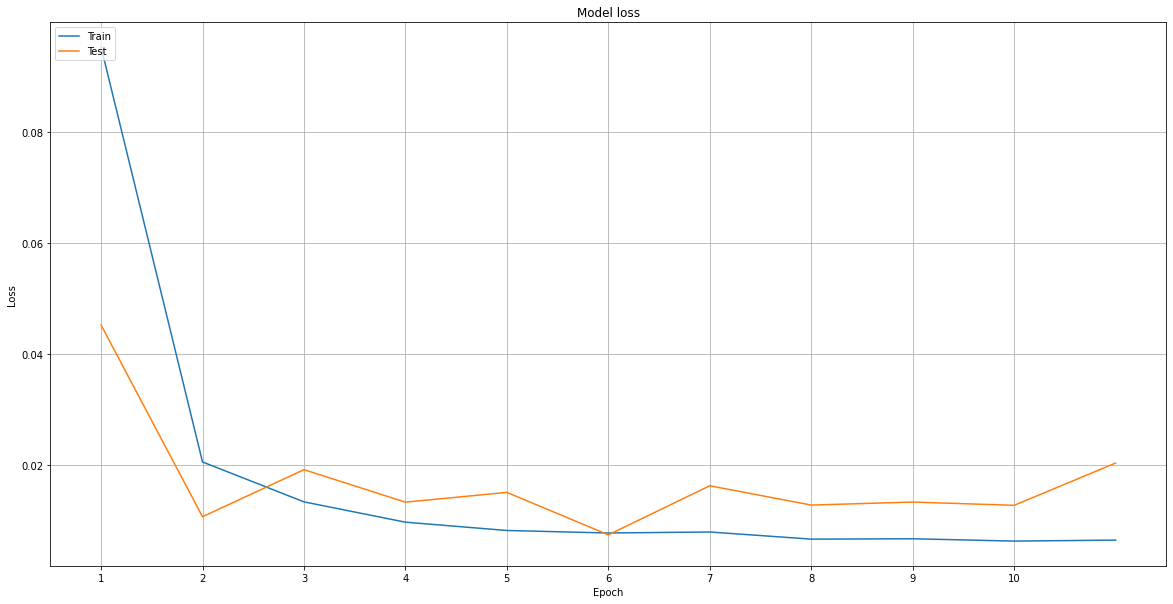

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 1.34
Mean Absolute Percentage Error (MAPE): 106.73 %
Median Absolute Percentage Error (MDAPE): 49.44 %


,MAE,MAPE,MDAPE
0,1.336583,106.725979,49.436706


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

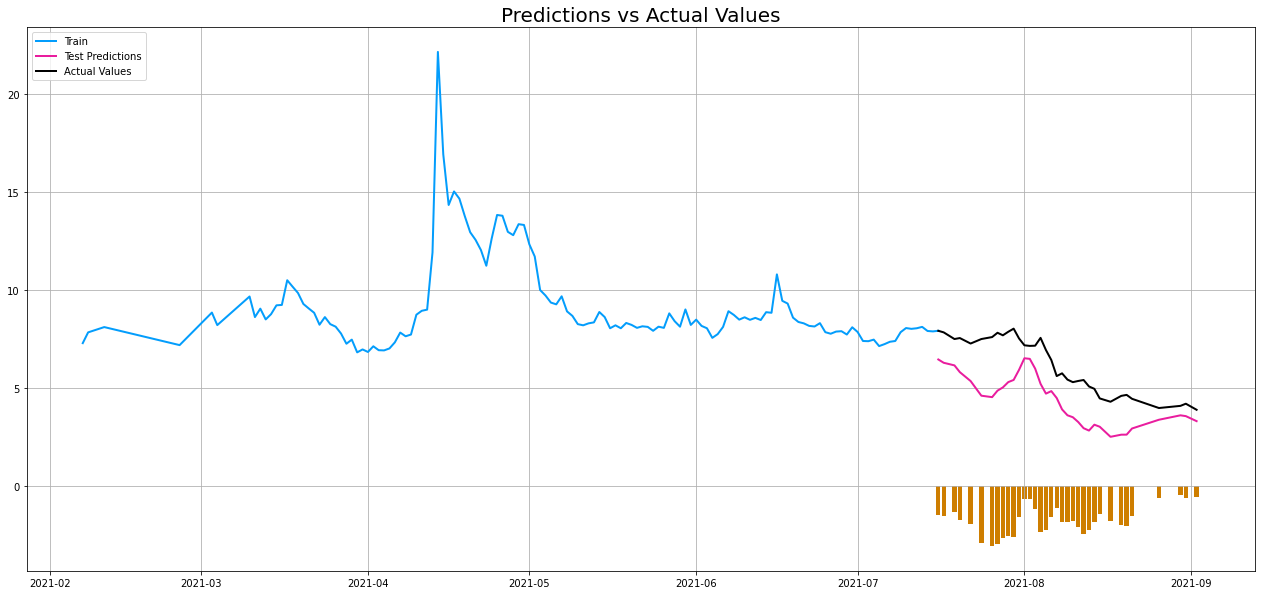

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [45]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '2D%Change', 'SD', '4D%Change', '6Dir', '3Dir', '5Dir', '4Dir', 'SD_log', 'Volume', 'Low', '7Dir', '7D%Change', '3D%Change', 'Dir', 'Open', '6D%Change', '2Dir', 'Daily%Change', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,7Dir(t-4),7D%Change(t-4),3D%Change(t-4),Dir(t-4),Open(t-4),6D%Change(t-4),2Dir(t-4),Daily%Change(t-4),High(t-4),Close(t-4)
17,13.95,2,11.0,11.0,5.5,100.000000,11.0,3.666667,100.0,11.0,...,1.0,2.327271,1.005021,0.0,14.780,2.476330,0.0,-1.263160,15.45,14.07
18,12.23,3,9.0,20.0,10.0,100.000000,20.0,6.666667,100.0,20.0,...,1.0,1.602333,-11.484774,0.0,14.050,2.649004,0.0,-0.852878,14.70,13.95
19,12.93,4,1.0,10.0,5.0,-90.909091,21.0,7.000000,100.0,21.0,...,1.0,1.618839,-3.087716,0.0,14.130,1.918821,0.0,-1.003580,14.40,13.81
28,10.98,4,1.0,1.0,0.5,100.000000,1.0,0.333333,100.0,1.0,...,0.0,-13.405017,-8.206686,1.0,11.925,-1.226489,0.0,0.582845,12.39,12.08
34,10.37,0,3.0,3.0,1.5,100.000000,3.0,1.000000,100.0,3.0,...,0.0,-15.653623,-6.463526,0.0,10.620,-16.142383,0.0,-8.574006,10.88,10.13


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,7D%Change(t-4),3D%Change(t-4),Dir(t-4),Open(t-4),6D%Change(t-4),2Dir(t-4),Daily%Change(t-4),High(t-4),Close(t-4),Prediction
235,4.04,1,2.0,2.0,1.0,-71.428571,9.0,3.000000,-80.000000,19.0,...,-8.464564,8.139532,1.0,4.550,-6.249999,1.0,1.086961,4.750,4.65,4.04
240,4.10,1,1.0,1.0,0.5,-50.000000,3.0,1.000000,100.000000,3.0,...,-4.618933,-6.561085,1.0,4.010,-10.217387,0.0,2.227727,4.190,4.13,4.10
243,4.05,0,2.0,20.0,10.0,-60.000000,25.0,8.333333,100.000000,25.0,...,-10.786512,-3.874094,0.0,4.060,-10.180996,0.0,-5.250597,4.110,3.97,4.05
244,3.89,1,1.0,3.0,1.5,-94.444444,21.0,7.000000,-80.000000,26.0,...,-7.239823,3.015072,1.0,4.020,-3.301884,0.0,3.274556,4.130,4.10,3.89
245,3.74,2,66.0,67.0,33.5,3200.000000,69.0,23.000000,266.666667,87.0,...,-3.537727,-2.386633,0.0,4.083,1.237628,1.0,-0.243896,4.219,4.09,3.74


In [47]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(140, 43)
(42, 43)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(133, 7, 43) (133,)
(35, 7, 43) (35,)
0.03457271703160053
0.03457271703160053


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.0993
Epoch 1: val_loss improved from inf to 0.05733, saving model to CLOV_Close_4shift_Baseline.h5
9/9 [==============================] - 6s 196ms/step - loss: 0.0993 - val_loss: 0.0573
Epoch 2/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0274
Epoch 2: val_loss improved from 0.05733 to 0.01875, saving model to CLOV_Close_4shift_Baseline.h5
9/9 [==============================] - 1s 80ms/step - loss: 0.0263 - val_loss: 0.0187
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.0164
Epoch 3: val_loss did not improve from 0.01875
9/9 [==============================] - 1s 69ms/step - loss: 0.0164 - val_loss: 0.0260
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.0117
Epoch 4: val_loss did not improve from 0.01875
9/9 [==============================] - 1s 68ms/step - loss: 0.0117 - val_loss: 0.0217
Epoch 5/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0100

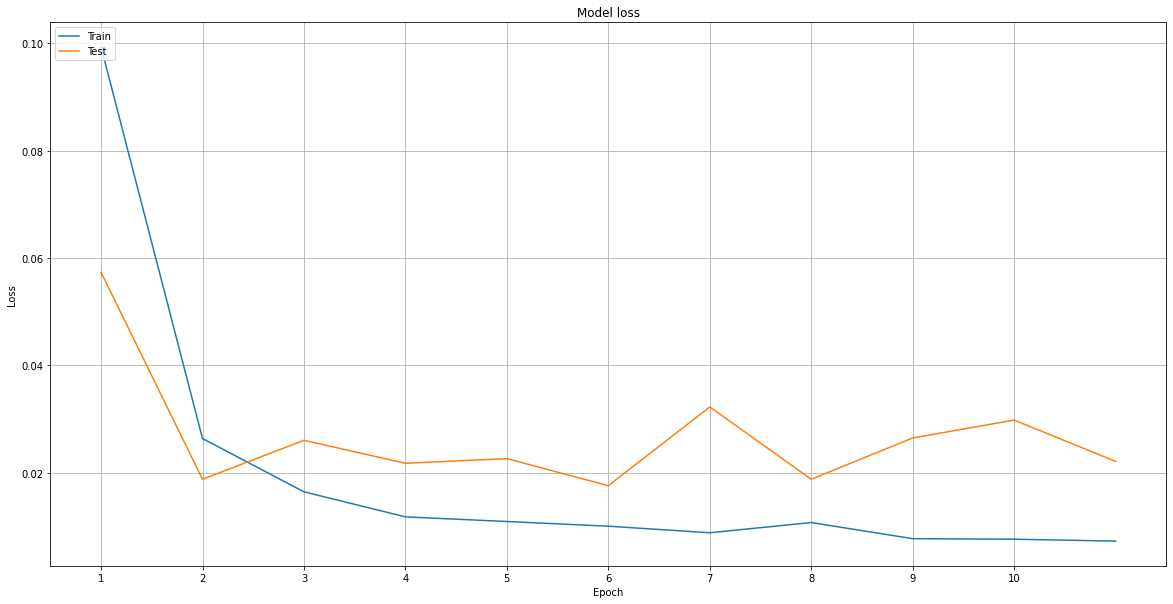

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 2.21
Mean Absolute Percentage Error (MAPE): 444.08 %
Median Absolute Percentage Error (MDAPE): 101.93 %


,MAE,MAPE,MDAPE
0,2.210313,444.080604,101.933888


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

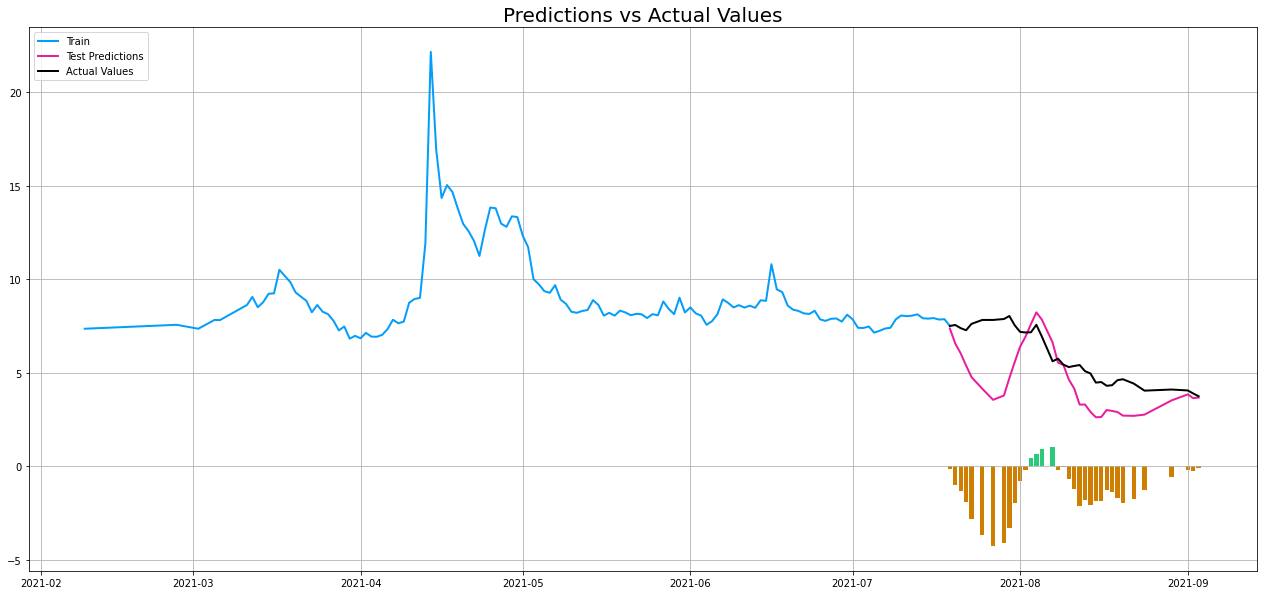

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [55]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['5D%Change', '2D%Change', 'SD', '4D%Change', '6Dir', '3Dir', '5Dir', '4Dir', 'SD_log', 'Volume', 'Low', '7Dir', '7D%Change', '3D%Change', 'Dir', 'Open', '6D%Change', '2Dir', 'Daily%Change', 'High']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 246


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,7Dir(t-7),7D%Change(t-7),3D%Change(t-7),Dir(t-7),Open(t-7),6D%Change(t-7),2Dir(t-7),Daily%Change(t-7),High(t-7),Close(t-7)
20,12.37,0,1.0,10.0,5.0,-90.909091,21.0,7.000000,100.0,21.0,...,1.0,2.327271,1.005021,0.0,14.78,2.476330,0.0,-1.263160,15.45,14.07
29,11.08,0,1.0,1.0,0.5,100.000000,1.0,0.333333,100.0,1.0,...,0.0,-9.485883,-3.325602,0.0,13.18,-10.522550,1.0,-5.015196,13.25,12.50
30,10.13,1,2.0,3.0,1.5,100.000000,3.0,1.000000,100.0,3.0,...,0.0,-14.030064,-2.910264,0.0,12.38,-13.906807,0.0,-3.919998,12.48,12.01
37,7.29,3,3.0,3.0,1.5,100.000000,3.0,1.000000,100.0,3.0,...,0.0,-15.653623,-6.463526,0.0,10.62,-16.142383,0.0,-8.574006,10.88,10.13
40,8.19,1,1.0,1.0,0.5,100.000000,1.0,0.333333,100.0,1.0,...,0.0,-16.961132,-7.206323,0.0,9.92,-13.204066,0.0,-3.192589,10.00,9.40


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,7D%Change(t-7),3D%Change(t-7),Dir(t-7),Open(t-7),6D%Change(t-7),2Dir(t-7),Daily%Change(t-7),High(t-7),Close(t-7),Prediction
236,4.13,2,7.0,17.0,8.5,133.333333,20.0,6.666667,100.0,20.0,...,-19.216421,-3.131988,1.0,4.17,-19.963031,0.0,0.697668,4.440,4.33,4.13
238,4.19,4,2.0,2.0,1.0,-71.428571,9.0,3.000000,-80.0,19.0,...,-8.464564,8.139532,1.0,4.55,-6.249999,1.0,1.086961,4.750,4.65,4.19
241,4.09,2,2.0,2.0,1.0,100.000000,2.0,0.666667,100.0,2.0,...,-5.777783,-8.817211,0.0,4.34,-1.395359,0.0,-4.072405,4.420,4.24,4.09
244,3.89,1,5.0,5.0,2.5,100.000000,5.0,1.666667,100.0,5.0,...,-13.478259,-6.132070,0.0,4.18,-14.408603,0.0,-3.631963,4.220,3.98,3.89
245,3.74,2,18.0,23.0,11.5,100.000000,23.0,7.666667,100.0,23.0,...,-9.892474,3.712874,1.0,3.94,-5.842691,1.0,5.276383,4.305,4.19,3.74


In [57]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(141, 43)
(42, 43)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(134, 7, 43) (134,)
(35, 7, 43) (35,)
0.11676448464461425
0.11676448464461425


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.0343
Epoch 1: val_loss improved from inf to 0.04455, saving model to CLOV_Close_7shift_Baseline.h5
9/9 [==============================] - 6s 197ms/step - loss: 0.0343 - val_loss: 0.0445
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.0151
Epoch 2: val_loss improved from 0.04455 to 0.03076, saving model to CLOV_Close_7shift_Baseline.h5
9/9 [==============================] - 1s 82ms/step - loss: 0.0151 - val_loss: 0.0308
Epoch 3/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0123
Epoch 3: val_loss improved from 0.03076 to 0.02276, saving model to CLOV_Close_7shift_Baseline.h5
9/9 [==============================] - 1s 79ms/step - loss: 0.0117 - val_loss: 0.0228
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.0099
Epoch 4: val_loss did not improve from 0.02276
9/9 [==============================] - 1s 69ms/step - loss: 0.0099 - val_loss: 0.0309
Epoch 5/100
9/9 [=====

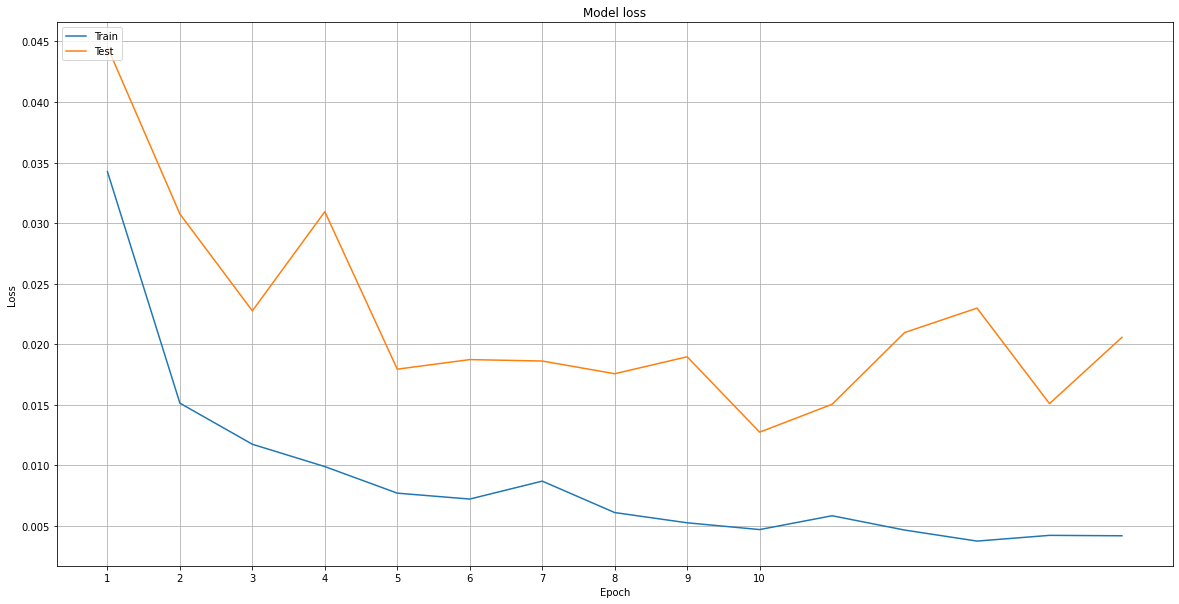

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 1.73
Mean Absolute Percentage Error (MAPE): 418.73 %
Median Absolute Percentage Error (MDAPE): 59.78 %


,MAE,MAPE,MDAPE
0,1.733175,418.726135,59.783985


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

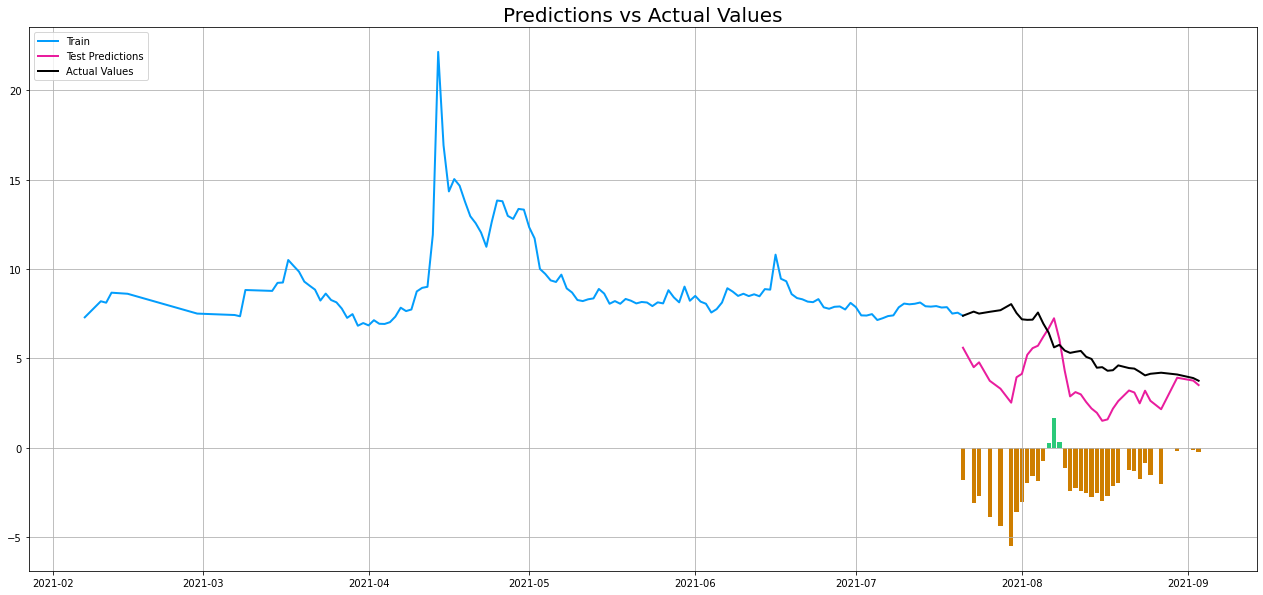

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## Overall Results

In [65]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,1.336583,0.997529
1,1dayshift,MAPE,106.725979,19.148167
2,1dayshift,MDAPE,49.436706,9.653800
3,4dayshift,MAE,2.210313,1.023906
4,4dayshift,MAPE,444.080604,19.188244
5,4dayshift,MDAPE,101.933888,8.673310
6,7dayshift,MAE,1.733175,1.357391
7,7dayshift,MAPE,418.726135,26.988675
8,7dayshift,MDAPE,59.783985,18.183361


In [66]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)